In [1]:
import yfinance as yf
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_PATH = '../../data/stocks'

# Data Fetching

In [60]:
bo = [
    '514448'
]

ns = [
    'PGHL'
]

tickers = [b + '.BO' for b in bo] + [n + '.NS' for n in ns]
tickers

['531201.BO',
 '543619.BO',
 '526506.BO',
 'TIPSINDLTD.NS',
 'PRUDENT.NS',
 'NUCLEUS.NS',
 'STYLAMIND.NS',
 'GANESHHOUC.NS',
 'BETA.NS',
 'ALLSEC.NS',
 'ACE.NS',
 'SCHNEIDER.NS',
 'FIEMIND.NS']

In [62]:
df = download_and_cache(tickers)
df

{'531201.BO':                    Open         High          Low        Close    Adj Close  \
 Date                                                                          
 2002-06-17    31.500000    31.500000    31.500000    31.500000    27.111504   
 2002-06-18    31.500000    31.500000    31.500000    31.500000    27.111504   
 2002-06-19    31.500000    31.500000    31.500000    31.500000    27.111504   
 2002-06-20    31.500000    31.500000    31.500000    31.500000    27.111504   
 2002-06-21    31.500000    31.500000    31.500000    31.500000    27.111504   
 ...                 ...          ...          ...          ...          ...   
 2024-08-14  6052.000000  6149.399902  5950.000000  6051.149902  6051.149902   
 2024-08-16  6089.000000  6205.000000  6089.000000  6175.899902  6175.899902   
 2024-08-19  6295.000000  6320.000000  6056.799805  6248.549805  6248.549805   
 2024-08-20  6365.000000  6365.000000  6110.000000  6216.399902  6216.399902   
 2024-08-21  6217.299805  6

In [63]:
close_arr = []
for t in tickers:
    close_arr.append(df[t]
                     .dropna()
                     .query('Volume > 0')[['Close']]
                     .rename(columns={'Close': t}))

df_close = pd.concat(close_arr,axis=1).dropna()
df_close

,531201.BO,543619.BO,526506.BO,TIPSINDLTD.NS,PRUDENT.NS,NUCLEUS.NS,STYLAMIND.NS,GANESHHOUC.NS,BETA.NS,ALLSEC.NS,ACE.NS,SCHNEIDER.NS,FIEMIND.NS
Date,,,,,,,,,,,,,
2022-10-10,328.475006,115.400002,230.000000,151.610001,693.799988,399.799988,1084.400024,389.649994,750.000000,494.399994,300.149994,180.300003,755.625000
2022-10-11,322.950012,121.150002,239.750000,150.039993,678.750000,401.149994,1093.699951,380.600006,755.000000,497.500000,287.500000,178.250000,775.250000
2022-10-12,332.274994,127.199997,250.000000,157.059998,659.549988,399.549988,1092.349976,390.450012,719.150024,502.049988,292.100006,179.100006,783.474976
2022-10-13,360.049988,133.550003,261.350006,154.945007,665.799988,399.399994,1076.500000,382.799988,715.000000,494.850006,280.600006,174.500000,792.974976
2022-10-14,364.850006,140.199997,269.799988,155.229996,695.549988,397.700012,1090.949951,381.149994,729.650024,465.799988,277.500000,174.350006,784.525024
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-14,6051.149902,1281.849976,1131.900024,713.650024,2700.149902,1142.199951,1861.599976,851.700012,1346.699951,980.599976,1233.800049,793.650024,1301.500000
2024-08-16,6175.899902,1293.000000,1188.449951,744.200012,2549.649902,1203.099976,1911.050049,874.700012,1379.000000,1021.500000,1264.050049,823.400024,1320.800049
2024-08-19,6248.549805,1341.599976,1245.250000,772.099976,2382.250000,1175.050049,1937.199951,913.250000,1391.300049,1091.099976,1310.900024,806.099976,1418.449951


<Axes: >

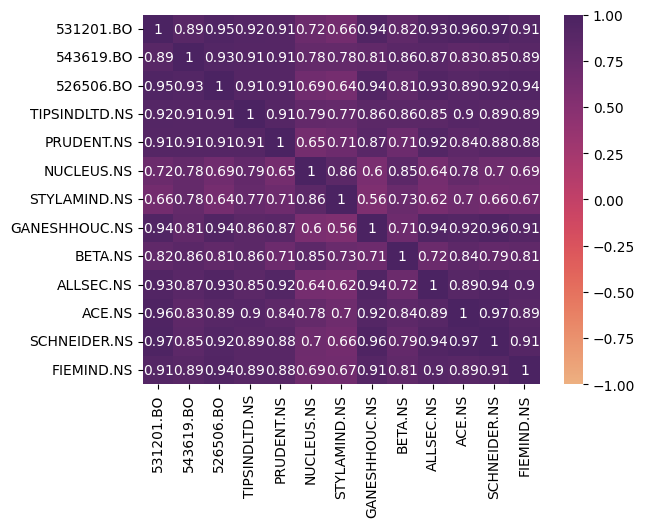

In [64]:
sns.heatmap(df_close.corr(), annot=True, vmin=-1, vmax=1, cmap='flare')

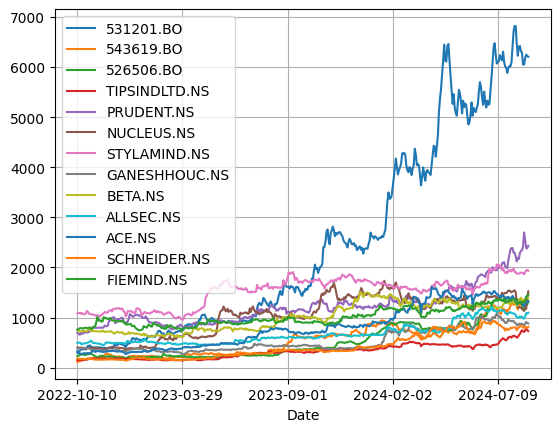

In [65]:
df_close.plot()
plt.grid()
plt.legend()

# Portfolio Analysis using SKFolio

In [66]:
from sklearn.model_selection import train_test_split, GridSearchCV

from skfolio.optimization import (
    InverseVolatility, 
    NestedClustersOptimization, 
    MeanRisk, 
    HierarchicalRiskParity, 
    EqualWeighted,
    RiskBudgeting
)
from skfolio.preprocessing import prices_to_returns
from skfolio.cluster import HierarchicalClustering, LinkageMethod
from skfolio import Population, RiskMeasure
from skfolio.model_selection import WalkForward
from skfolio.distance import PearsonDistance, KendallDistance

In [67]:
ret = df_close.pct_change().dropna()
X_train, X_test = train_test_split(ret, test_size=0.30, shuffle=False)
X_train.shape

(300, 13)

### Variance Minimization

In [68]:
benchmark = InverseVolatility()
benchmark.fit(X_train)

InverseVolatility()

### Hierarchical Risk Minimization

In [69]:
hier = HierarchicalRiskParity(
    risk_measure=RiskMeasure.CVAR
)
hier.fit(X_train)

HierarchicalRiskParity(risk_measure=CVaR)

## Model Comparison

In [70]:
models = [benchmark, hier]
pop = Population([m.predict(X_test) for m in models])
pop.set_portfolio_params(compounded=True)
pop.plot_cumulative_returns(log_scale=False)

In [71]:
pop.summary()

,InverseVolatility,HierarchicalRiskParity
Mean,0.31%,0.31%
Annualized Mean,77.12%,77.03%
Variance,0.027%,0.026%
Annualized Variance,6.68%,6.52%
Semi-Variance,0.015%,0.015%
Annualized Semi-Variance,3.83%,3.73%
Standard Deviation,1.63%,1.61%
Annualized Standard Deviation,25.85%,25.54%
Semi-Deviation,1.23%,1.22%
Annualized Semi-Deviation,19.57%,19.31%


In [73]:
pop.composition() * 1_00_000

,InverseVolatility,HierarchicalRiskParity
asset,,
STYLAMIND.NS,9962.030860,8923.533210
ALLSEC.NS,9847.439603,8098.463374
FIEMIND.NS,8624.111825,7779.874699
TIPSINDLTD.NS,8341.531094,7285.792815
BETA.NS,8295.831804,11252.262021
ACE.NS,8235.479077,6704.578730
PRUDENT.NS,8093.231772,5430.404798
SCHNEIDER.NS,7776.157548,10539.996809
GANESHHOUC.NS,7669.763894,6311.997729
